In [1]:
import sys
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.distributions as dist

sys.path.append("..")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

<module 'src.models' from '/home/jhaberbe/Projects/Personal/ate/notebook/../src/models.py'>

# Data Setup

In [ ]:
import torch
import wandb
import scanpy as sc
import torch.distributions as dist

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
adata = adata[adata.obs["folder"].eq("05-27")]
adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

# Data Setup
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)
data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
category_mapping

# Model Setup
nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

# Send to proper devices.
device = "cuda"
data.to(device)
nb_model.to(device)

# Training routine.
optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 2_000

In [ ]:
wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()

    logits, dispersion = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area, 
        data.edge_index
    )

    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
    if epoch % 100 == 0:
        print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇██
log_likelihood,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,2000
log_likelihood,-158.69774
loss,158.69774


{'epoch': 1, 'loss': 158.69679260253906, 'log_likelihood': -158.69679260253906}
{'epoch': 101, 'loss': 158.6080780029297, 'log_likelihood': -158.6080780029297}
{'epoch': 201, 'loss': 158.52264404296875, 'log_likelihood': -158.52264404296875}
{'epoch': 301, 'loss': 158.44049072265625, 'log_likelihood': -158.44049072265625}
{'epoch': 401, 'loss': 158.3619842529297, 'log_likelihood': -158.3619842529297}
{'epoch': 501, 'loss': 158.28530883789062, 'log_likelihood': -158.28530883789062}
{'epoch': 601, 'loss': 158.21139526367188, 'log_likelihood': -158.21139526367188}
{'epoch': 701, 'loss': 158.13986206054688, 'log_likelihood': -158.13986206054688}
{'epoch': 801, 'loss': 158.07040405273438, 'log_likelihood': -158.07040405273438}
{'epoch': 901, 'loss': 158.00335693359375, 'log_likelihood': -158.00335693359375}
{'epoch': 1001, 'loss': 157.93719482421875, 'log_likelihood': -157.93719482421875}
{'epoch': 1101, 'loss': 157.87266540527344, 'log_likelihood': -157.87266540527344}
{'epoch': 1201, 'los

In [110]:
torch.save(nb_model.state_dict(), "../models/gatv2_nb_model.pth")
nb_model.load_state_dict(torch.load("../models/gatv2_nb_model.pth"))

<All keys matched successfully>

# Example of Treatment Effect
- For example, what is the expected effect of lipid droplets, conditioned on the neighborhood.

In [539]:
def perform_lipid_perturbation(
        adata,
        data,
        cell_type,
        nb_model
    ):
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)

    results = {}

    for idx in tqdm(indices):
        x_clone = data.x.clone()
        lipid_droplet_area_clone = data.lipid_droplet_area.clone()
        lipid_droplet_area_clone[idx] = 0.0
        nb_model.eval()
        with torch.no_grad():
            logits, dispersion = nb_model(
                data.cell_type_encoded.int(), 
                data.lipid_droplet_area, 
                data.edge_index
            )

            results[idx] = logits[idx].cpu().detach()

    treatment = pd.DataFrame(
        results, 
        index=adata.var_names
    ).T

    logits, _ = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area > 0, 
        data.edge_index
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return (treatment - null) \
        .assign(mean_area = np.log1p(adata.obs["lipid_droplet_area"]).iloc[treatment.index].tolist())

# Visualization

Could probably be done with gaussian processes.
- Maybe the output linear layer could be done with GPs too!

P2RY12    -0.183714
TMEM119   -0.133875
TRAC      -0.131310
PAX6      -0.124205
ELOVL2    -0.115807
LYVE1     -0.107315
APOE      -0.087177
STK32B    -0.080431
CD163     -0.074407
GJA1      -0.070749
GPNMB     -0.070337
STAT3     -0.067542
SREBF1    -0.059258
OPALIN    -0.053792
TRIL      -0.050213
PLIN5     -0.049377
TFEB      -0.049033
THBS1     -0.045727
MKI67     -0.041047
PCSK6     -0.040934
HILPDA    -0.040893
DCN       -0.038849
CLDN11    -0.038775
CPT1B     -0.026378
REL       -0.025491
FGF1      -0.020361
HSPA1B    -0.019042
NDST4     -0.012371
IL7R      -0.009883
SOX4       0.005793
EFHD1      0.006588
NPY1R      0.009219
GALC       0.010327
CCL4       0.018231
CCK        0.021748
RAB7A      0.025671
ADAMTS3    0.029735
NPC2       0.038206
ROS1       0.045961
DNER       0.052518
TPH2       0.114909
dtype: float64

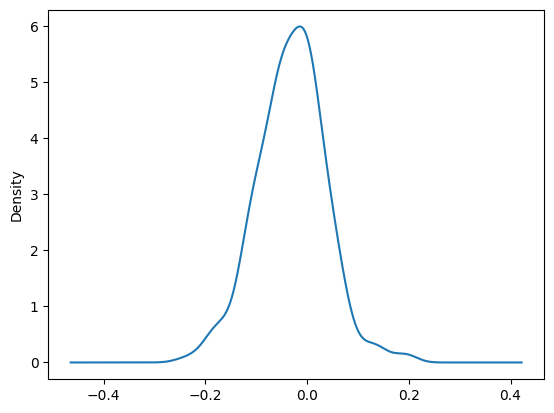

In [529]:
mean_area = np.log1p(adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].obs["lipid_droplet_area"])

expressed = (adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].layers["transcript"] > 1).mean(axis=0) > .3

(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).plot.kde()
(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).sort_values()[expressed]

<Axes: xlabel='mean_area', ylabel='TPH2'>

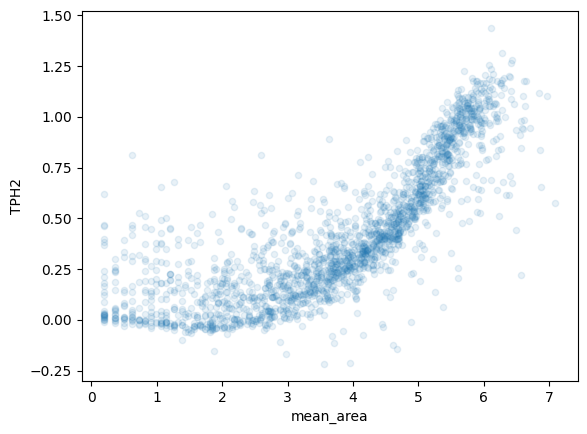

In [530]:
(treatment - null).assign(mean_area = mean_area.tolist()).plot.scatter(
    x="mean_area",
    y="TPH2",
    alpha = 0.1
)

# Changes cell type in the neighborhood.

In [538]:
import torch
from tqdm import tqdm
import random
import pandas as pd

import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_perturbation(
        adata,
        data,
        cell_type_testing,
        cell_type_perturb,
        category_mapping,
        nb_model
    ):

    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]

    # full edge index
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # remap everything to local subgraph
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset]

        center_idx = mapping.item()  # local index of target cell
        num_nodes = len(subset)

        # Find neighbors within the subgraph (1-hop)
        neighbors = sub_edge_index[1][sub_edge_index[0] == center_idx].tolist()
        if not neighbors:
            continue  # skip if isolated

        chosen_neighbor = random.choice(neighbors)
        i = 0
        while (cell_type_clone[chosen_neighbor].argmax() == target_cell_type) and i < 10:
            chosen_neighbor = random.choice(neighbors)
            i += 1

        # Replace cell type
        cell_type_clone[chosen_neighbor][cell_type_clone[chosen_neighbor].argmax()] = 0
        cell_type_clone[chosen_neighbor][target_cell_type] = 1

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null


pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

  0%|          | 0/13 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [471]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (average_treatment_effect.mean(axis=0))[mean_expression > 0.5].abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if (mean_expression.loc[gene] > 0.5) else None)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)


<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

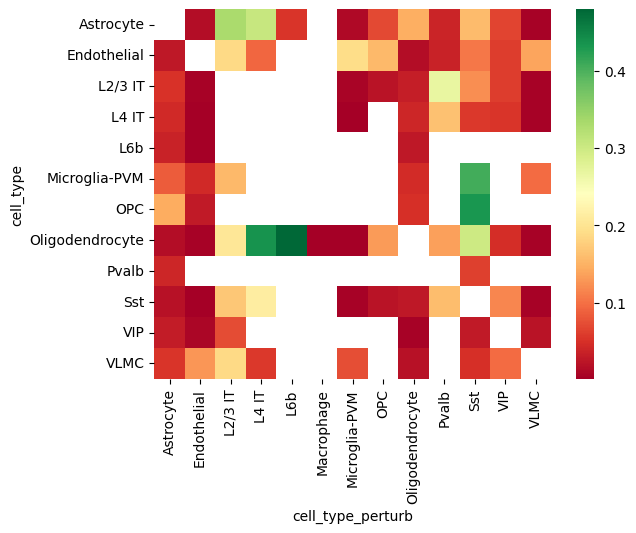

In [472]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

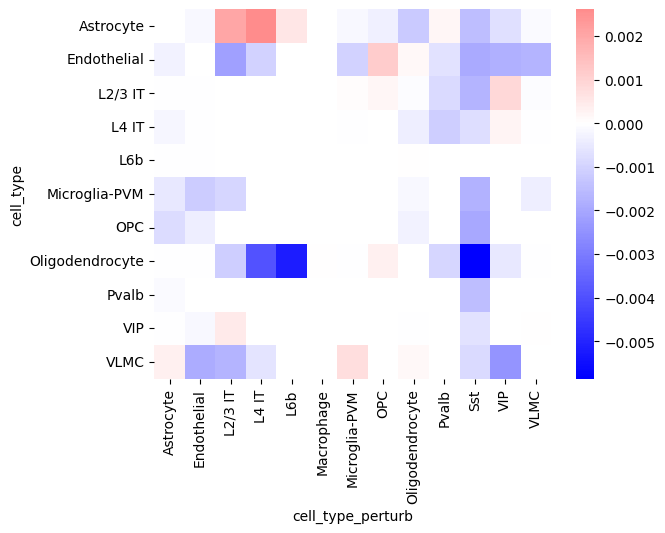

In [486]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(
    index="cell_type", 
    columns="cell_type_perturb", 
    values="LAMP1"
)
sns.heatmap(heatmap, cmap="bwr", center=0)

# What's the effect of inducing lipid droplet changes in a cell.

- Suppose we want to see what the effect is on a cell if we change the amount of lipid in its' neighboring cells, where will the effect be strongest.

In [537]:
import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_lipid_perturbation(
    adata, 
    data, 
    cell_type_testing, 
    cell_type_perturb, 
    category_mapping,
    new_lipid_value=0.0, 
    min_lipid_size=4.0
):
    # Todo: adjust so that we can add new bounds, question addition vs removal of lipid droplet.
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0.0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]


    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # Get subgraph feature tensors
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset].clone()

        center_idx = mapping.item()  # local index of target cell

        # Find matching cell type in subgraph (excluding the target)
        candidate_indices = [
            i for i in range(len(subset))
            if ((i != center_idx) & (cell_type_clone[i].argmax().item() == target_cell_type) & (lipid_droplet_area[i] > min_lipid_size))
        ]

        if not candidate_indices:
            continue  # skip if no perturbable cell found

        chosen_perturb_idx = random.choice(candidate_indices)

        # Replace lipid droplet value of that cell
        lipid_droplet_area[chosen_perturb_idx] = new_lipid_value

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_lipid_perturbation(
            adata, 
            data, 
            cell_type, 
            cell_type_perturb, 
            category_mapping,
            new_lipid_value=0.0
        )
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

  0%|          | 0/13 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [490]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

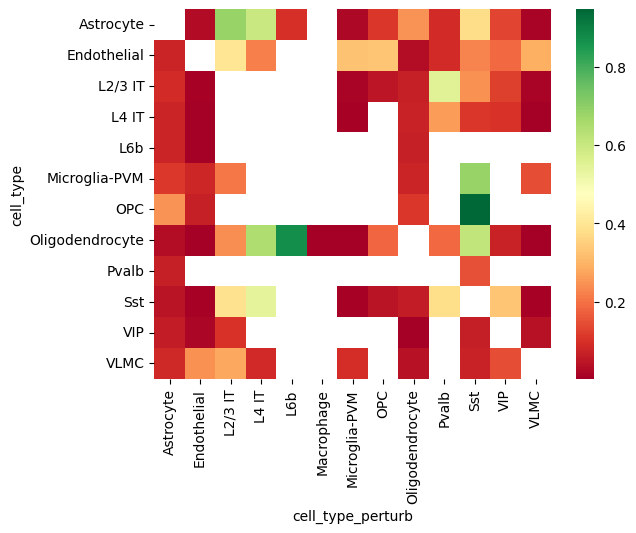

In [491]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

# Generalized Pipeline

In [ ]:
# Pipeline to test all specimens:
import torch
import wandb
import scanpy as sc
import torch.distributions as dist

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
for folder in adata.obs["folder"].unique()
    adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
    adata = adata[adata.obs["folder"].eq(folder)]
    adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

    # Data Setup
    data = utils.generate_torch_geometric_data(adata)
    data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
    data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
    data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
    data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
    data.size_factors = utils.counts_to_size_factors(data.total_counts)
    data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

    category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
    category_mapping

    # Model Setup
    nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

    # Send to proper devices.
    device = "cuda"
    data.to(device)
    nb_model.to(device)

    # Training routine.
    optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
    num_epochs = 5_000

    wandb.init(project="ate", name=folder)

    for epoch in range(num_epochs):
        nb_model.train()
        optimizer.zero_grad()

        logits, dispersion = nb_model(
            data.cell_type_encoded.int(), 
            data.lipid_droplet_area, 
            data.edge_index
        )

        nb_dist = dist.NegativeBinomial(
            logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
            total_count=dispersion
        )
        log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
        loss = -log_likelihood
        loss.backward()
        optimizer.step()
        wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
        if epoch % 100 == 0:
            print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

    torch.save(nb_model.state_dict(), f"../models/{folder}.pth")
    nb_model.load_state_dict(torch.load(f"../models/{folder}.pth"))

    lipid_perturbation = {
        cell_type: perform_lipid_perturbation(adata, data, cell_type, nb_model)
        for cell_type in adata.obs["cell_type"].unique()
    }

    neighbor_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    neighbor_lipid_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_lipid_perturbation(
                adata, 
                data, 
                cell_type, 
                cell_type_perturb, 
                category_mapping,
                new_lipid_value=0.0
            )
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    # Ensure the output directory exists
    os.makedirs(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}", exist_ok=True)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/lipid_perturbation.pickle", "wb") as f:
        pickle.dump(lipid_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_lipid_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_lipid_perturbation, f)


/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR Problem finishing run


MailboxClosedError: 